# Modeling relative strain prevalence

This notebook explores Pyro models for forecasting relative strain prevalance based on GISAID sequence data labeled with Pangolin lineage and amino acid mutation features.

In [92]:
import math
import pickle
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO, Trace_ELBO
from pyro.infer.autoguide import AutoDelta, AutoNormal, init_to_median
from pyro.infer.reparam import HaarReparam
from pyro.optim import Adam, ClippedAdam
from pyrocov import pangolin
from pyrocov.geo import gisaid_to_jhu_location, parse_date, pd_to_torch, read_csv

matplotlib.rcParams['figure.dpi'] = 200

## Loading data

We'll use all GISAID data. You'll need to request a feed from gisaid.org, download, then run
```sh
python preprocess_gisaid.py
nextclade --input-fasta results/gisaid.subset.fasta \
          --output-tsv results/gisaid.subset.tsv
python featurize_nextclade.py
```

In [75]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Training on {} rows with columns:".format(len(columns["day"])))
print(", ".join(columns.keys()))

Training on 703784 rows with columns:
accession_id, collection_date, location, add_location, lineage, day


In [76]:
lineages = list(map(pangolin.compress, columns["lineage"]))
print(f"Top 12 of {len(set(lineages))} lineages")
print("-" * 30)
for lineage, count in Counter(lineages).most_common(12):
    print(f"{count: >10d} {lineage}")

Top 12 of 880 lineages
------------------------------
    139077 B.1.1.7
     91343 B.1.177
     59806 B.1
     50428 B.1.2
     21325 B.1.1.29
     18591 B.1.160
     12352 D.2
      9349 B.1.177.21
      8367 C
      8103 B.1.258
      7921 B.1.221
      7617 B.1.1.284


In [77]:
locations = columns["location"]
print(f"Top 12 of {len(set(locations))} GISAID locations")
print("-" * 30)
for location, count in Counter(locations).most_common(12):
    print(f"{count: >10d} {location}")

Top 12 of 6976 GISAID locations
------------------------------
    221657 Europe / United Kingdom / England
     29558 Europe / United Kingdom / Wales
     21546 Europe / Denmark / Hovedstaden
     20522 Asia / Japan
     18766 Europe / United Kingdom / Scotland
     18549 North America / USA / Texas / Houston
     13654 Oceania / Australia / Victoria
      8455 Europe / Denmark / Syddanmark
      7777 North America / USA / Michigan
      7687 North America / USA / California
      7532 Europe / Denmark / Midtjylland
      6710 Europe / Denmark / Sjaelland


In [78]:
aa_features = torch.load("results/nextclade.features.pt")
print(aa_features.keys())

dict_keys(['lineages', 'mutations', 'features'])


In [79]:
print(aa_features["features"].shape)

torch.Size([880, 7527])


We'll account for epidemiological dynamics in the form of random drift on top of our logistic growth model. Since random drift is inversely proportional to the local number of infections, we'll need a new data source for the number of infections in each region. We'll use JHU's confirmed case counts time series as a proxy for the number of total infections in each region.

In [80]:
us_cases_df = read_csv("time_series_covid19_confirmed_US.csv")
global_cases_df = read_csv("time_series_covid19_confirmed_global.csv")
case_data = torch.cat([
    pd_to_torch(us_cases_df, columns=slice(11, None)),
    pd_to_torch(global_cases_df, columns=slice(4, None)),
]).T
sample_region, sample_matrix, region_tuples = gisaid_to_jhu_location(
    columns, us_cases_df, global_cases_df
)
num_gisaid_regions, num_jhu_regions = sample_matrix.shape

In [81]:
print(case_data.shape)
print(sample_region.shape)
print(sample_matrix.shape)
print(len(set(columns['location'])))
print(len(columns['location']))

torch.Size([412, 3614])
torch.Size([703784])
torch.Size([6976, 3614])
6976
703784


## Aggregating regions

We'll aggregate locations by either US state, UK regions, or other country.

In [82]:
features = aa_features["features"]
lineages = list(map(pangolin.compress, columns["lineage"]))
lineage_id_inv = list(map(pangolin.compress, aa_features["lineages"]))
lineage_id = {k: i for i, k in enumerate(lineage_id_inv)}

In [83]:
sparse_data = Counter()
location_id = {}
quotient = {}
for day, location, lineage in zip(columns["day"], columns["location"], lineages):
    parts = location.split("/")
    if len(parts) < 2:
        continue
    parts = [p.strip() for p in parts[:3]]
    if parts[1] not in ("USA", "United Kingdom"):
        parts = parts[:2]
    quotient[location] = " / ".join(parts)
    p = location_id.setdefault(quotient[location], len(location_id))
    s = lineage_id[lineage]
    t = day // 7
    sparse_data[t, p, s] += 1

In [84]:
T = 1 + max(columns["day"]) // 7
P = len(location_id)
S = len(lineage_id)
weekly_strains = torch.zeros(T, P, S)
for (t, p, s), n in sparse_data.items():
    weekly_strains[t, p, s] = n
print(weekly_strains.shape, weekly_strains.shape.numel())

torch.Size([66, 226, 880]) 13126080


In [85]:
quotient_matrix = torch.zeros(len(location_id), num_jhu_regions)
gisaid_id = {k: i for i, k in enumerate(sorted(quotient))}
for g, q in quotient.items():
    quotient_matrix[location_id[q]] += sample_matrix[gisaid_id[g]]
count_data = case_data @ quotient_matrix.T

Convert from daily to weekly observations.

In [86]:
start_date = parse_date("12/01/19")
jhu_start_date = parse_date(us_cases_df.columns[11])
assert start_date < jhu_start_date
dt = (jhu_start_date - start_date).days
weekly_cases = torch.zeros(T, P)
for w in range(7):
    t0 = (w + dt) // 7
    w_data = count_data[w::7]
    w_data = w_data[:len(weekly_cases[t0:t0+len(w_data)])]  # allow jhu after end of gisaid
    weekly_cases[t0:t0+len(w_data)] += w_data
print(weekly_cases.shape)

torch.Size([66, 226])


Heuristically estimat the number of infections. This need not be very accurate.

In [87]:
response_rate = 0.05
weekly_infections = torch.maximum(weekly_cases, weekly_strains.sum(-1)) / response_rate
weekly_infections.clamp_(min=1 / response_rate);

## Constructing a Pyro model

Our first model is a logistic growth model with a Dirichlet-multinomial likelihood (the multivariate generalization of negative binomial likelihood). This ignores any spatial structure across regions.

In [167]:
def model(weekly_strains, weekly_infections, features, feature_scale=1.0):
    assert weekly_strains.shape[-1] == features.shape[0]
    assert weekly_infections.shape == weekly_strains.shape[:2]
    T, P, S = weekly_strains.shape
    S, F = features.shape
    time_plate = pyro.plate("time", T, dim=-2)
    dtime_plate = pyro.plate("dtime", T - 1, dim=-2)
    place_plate = pyro.plate("place", P, dim=-1)
    time = torch.arange(float(T)) * 7 / 365.25  # in years
    time -= time.max()

    # Assume relative growth rate depends on kmer features but not time or place.
    trend_coef = pyro.sample(
        "trend_coef", dist.Laplace(0, feature_scale).expand([F]).to_event(1)
    )
    trend = pyro.deterministic("trend", trend_coef @ features.T)

    # Sample level from an improper uniform; we'll encode the prior as a factor graph.
    with time_plate, place_plate:
        rep = HaarReparam(dim=-3, experimental_allow_batch=True)
        with poutine.reparam(config={"level": rep}):
            level = pyro.sample(
                "level", dist.Normal(0, 1).expand([T, P, S]).to_event(1).mask(False)
            )

    # Add process noise depending on time, place, and strain, but with a shared scale.
    noise_level = pyro.sample("noise_level", dist.LogNormal(0, 1))
    noise_scale = noise_level * level[1:].neg().exp().log1p().sqrt()
    with dtime_plate, place_plate:
        pyro.sample(
            "dynamics",
            dist.Normal(0, noise_scale).to_event(1),
            obs=level[1:] - level[:-1],
        )

    # Finally observe overdispersed counts.
    concentration = pyro.sample("concentration", dist.LogNormal(2, 4))
    strain_probs = (level + trend * time[:, None, None]).softmax(-1)
    with time_plate, place_plate:
        pyro.sample(
            "obs",
            dist.DirichletMultinomial(
                total_count=weekly_strains.sum(-1).max(),
                concentration=concentration * strain_probs,
                is_sparse=True,  # uses a faster algorithm
            ),
            obs=weekly_strains,
        )

## Fitting the model

We'll use simple MAP estimation via Pyro's SVI and an `AutoDelta` guide. I'm defining a custom initialization function to initialize forecasts to uniformly even rather than random.

In [168]:
def init_loc_fn(site):
    if site["name"] in ("level", "trend_coef", "trend", "trend_haar"):
        return torch.zeros(site["fn"].shape())
    if site["name"] == "noise_level":
        return torch.full(site["fn"].shape(), 0.02)
    if site["name"] == "concentration":
        return torch.full(site["fn"].shape(), 5.0)
    return init_to_median(site)

Traning guide with 13133609 parameters:
step    0 loss = -357	conc. = 5.26	noise. = 0.0951	
step    1 loss = -329	conc. = 5.53	noise. = 0.0905	
step    2 loss = -354	conc. = 5.58	noise. = 0.0861	
step    3 loss = -362	conc. = 5.52	noise. = 0.0819	
step    4 loss = -373	conc. = 5.39	noise. = 0.0779	
step    5 loss = -392	conc. = 5.38	noise. = 0.0741	
step    6 loss = -415	conc. = 5.43	noise. = 0.0705	
step    7 loss = -425	conc. = 5.54	noise. = 0.067	
step    8 loss = -437	conc. = 5.61	noise. = 0.0638	
step    9 loss = -456	conc. = 5.59	noise. = 0.0607	
step   10 loss = -467	conc. = 5.51	noise. = 0.0577	
step   11 loss = -479	conc. = 5.51	noise. = 0.0549	
step   12 loss = -494	conc. = 5.58	noise. = 0.0522	
step   13 loss = -506	conc. = 5.69	noise. = 0.0497	
step   14 loss = -518	conc. = 5.72	noise. = 0.0472	
step   15 loss = -531	conc. = 5.68	noise. = 0.0449	
step   16 loss = -542	conc. = 5.59	noise. = 0.0427	
step   17 loss = -552	conc. = 5.58	noise. = 0.0407	
step   18 loss = -564	con

Text(0, 0.5, 'loss')

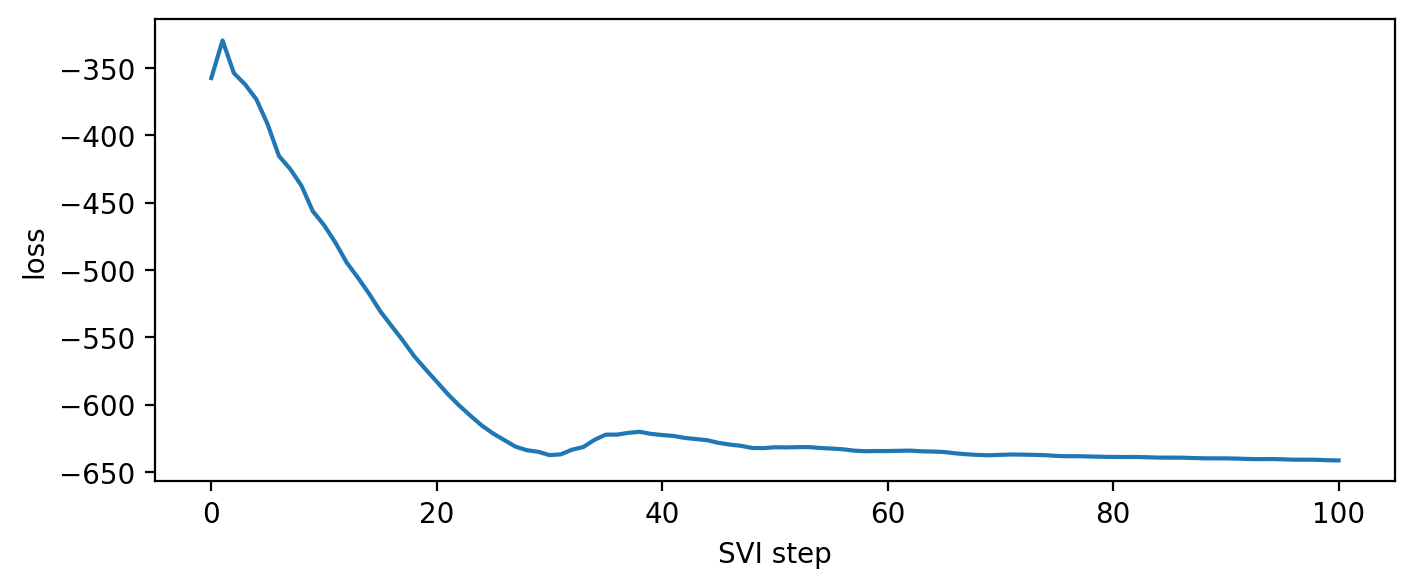

In [177]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(20210309)
truncate = False
t = slice(10 if truncate else None)
p = slice(12 if truncate else None)

guide = AutoDelta(model, init_loc_fn=init_loc_fn)
# Initialize guide so we can count parameters.
guide(weekly_strains[t, p], weekly_infections[t, p], features)
print("Traning guide with {} parameters:".format(sum(p.numel() for p in guide.parameters())))
optim = ClippedAdam({"lr": 0.05, "betas": (0.8, 0.99)})
svi = SVI(model, guide, optim, Trace_ELBO())
losses = []
num_obs = weekly_strains.count_nonzero()
for step in range(101):
    loss = svi.step(weekly_strains[t, p], weekly_infections[t, p], features) / num_obs
    assert not math.isnan(loss)
    losses.append(loss)
    if step % 1 == 0:
        median = guide.median()
        concentration = median["concentration"].item()
        noise_level = median["noise_level"].item()
        print(f"step {step: >4d} loss = {loss:0.3g}\t"
              f"conc. = {concentration:0.3g}\t"
              f"noise. = {noise_level:0.3g}\t")

plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss");

After fitting, we can extract a point estimate via the `guide.median()` method, which returns a dict.

In [178]:
with torch.no_grad():
    median = {k: v.detach() for k, v in guide.median().items()}
median["trend"] = median["trend_coef"] @ features.T
print(", ".join(median.keys()))

trend_coef, level_haar, noise_level, concentration, trend


## Interpreting results

Since we're fitting relative growth rate and prevalence, we can characterize all lineages by these quantities. Note the relative transmissibility looks suspciously diverse, suggesting we should probably add process noise to our model.

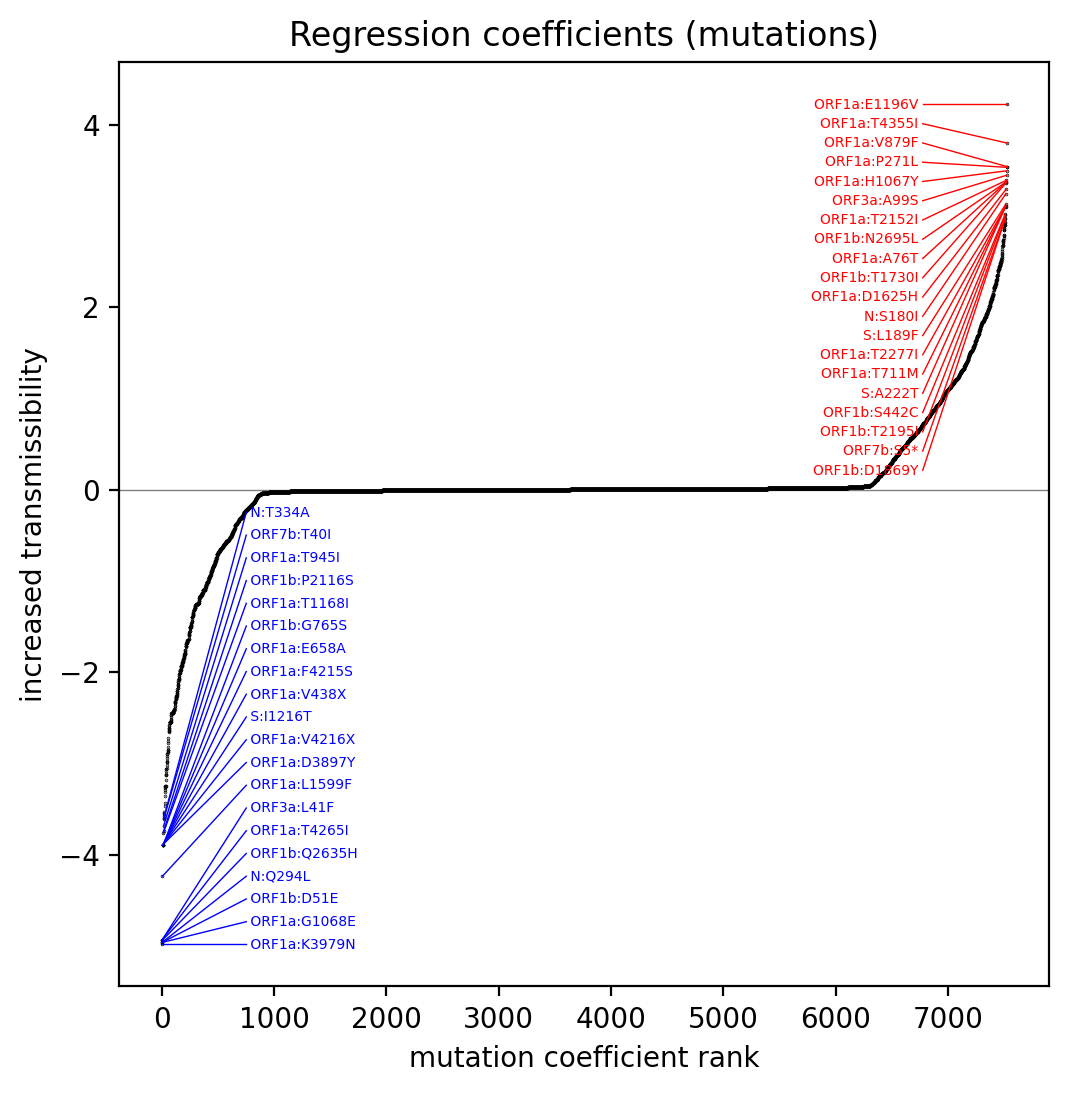

In [179]:
mutations = aa_features['mutations']
xs, idx = median["trend_coef"].sort(0)
assert len(idx) == len(mutations)
plt.figure(figsize=(6, 6))
plt.title("Regression coefficients (mutations)")
plt.plot(xs, 'k.', lw=0, markersize=0.5)
plt.axhline(0, color='black', lw=0.5, alpha=0.5)
plt.xlabel("mutation coefficient rank")
plt.ylabel("increased transmissibility")

I = len(idx)
for i in range(20):
    x = I / 10
    y = xs.min() * (1 - i / 20)
    plt.plot([i, x], [xs[i], y], color='blue', lw=0.5)
    plt.text(x, y, " " + mutations[int(idx[i])], fontsize=5, color='blue',
             verticalalignment="center", horizontalalignment="left")
for i in range(I - 20, I):
    x = I - I / 10
    y = xs.max() * (1 - (I - i - 1) / 20)
    plt.plot([i, x], [xs[i], y], color='red', lw=0.5)
    plt.text(x, y, mutations[int(idx[i])] + " ", fontsize=5, color='red',
             verticalalignment="center", horizontalalignment="right")

We can also examine coefficients of some known mutations.

In [174]:
for name in ["N501Y", "D614G"]:
    i, = [i for i, m in enumerate(mutations) if name in m]
    coef = float(median["trend_coef"][i])
    print(f"{name} increases transmissibility by {coef:0.3g}")

N501Y increases transmissibility by 0.658
D614G increases transmissibility by 0.972


In [175]:
edges = pangolin.find_edges(list(lineage_id))
edges = torch.tensor([[lineage_id[u], lineage_id[v]] for u, v in edges], dtype=torch.long)

def plot_prevalence(place_query="", max_len=999):
    ids = [i for name, i in location_id.items() if place_query in name]
    local_lineages = weekly_strains.sum(0)[ids].sum(0).nonzero(as_tuple=True)[0]
    assert ids, "no locations matching " + place_query
    log_rate = median["trend"] / 12
    log_init = median["log_init"][ids].logsumexp(0)
    plt.figure(figsize=(8, 6))
    plt.scatter(log_rate[local_lineages], log_init[local_lineages], s=10, color="#ff7777")
    X, Y = [], []
    for u, v in edges.tolist():
        if u in local_lineages and v in local_lineages:
            X.extend([log_rate[u], log_rate[v], None])
            Y.extend([log_init[u], log_init[v], None])
    plt.plot(X, Y, color="#ff7777", lw=0.5)
    for name, i in lineage_id.items():
        plt.text(log_rate[i], log_init[i] + 0.08, name,
                 fontsize=5, horizontalalignment="center")
    plt.ylabel("log prevalence")
    plt.xlabel("relative transmissibility (log monthly growth rate)")
    plt.title(f"Prevalence and transmissibility of {len(local_lineages)} lineages"
              + (" in " + place_query if place_query else " globally"));
    
plot_prevalence(max_len=7)

KeyError: 'log_init'

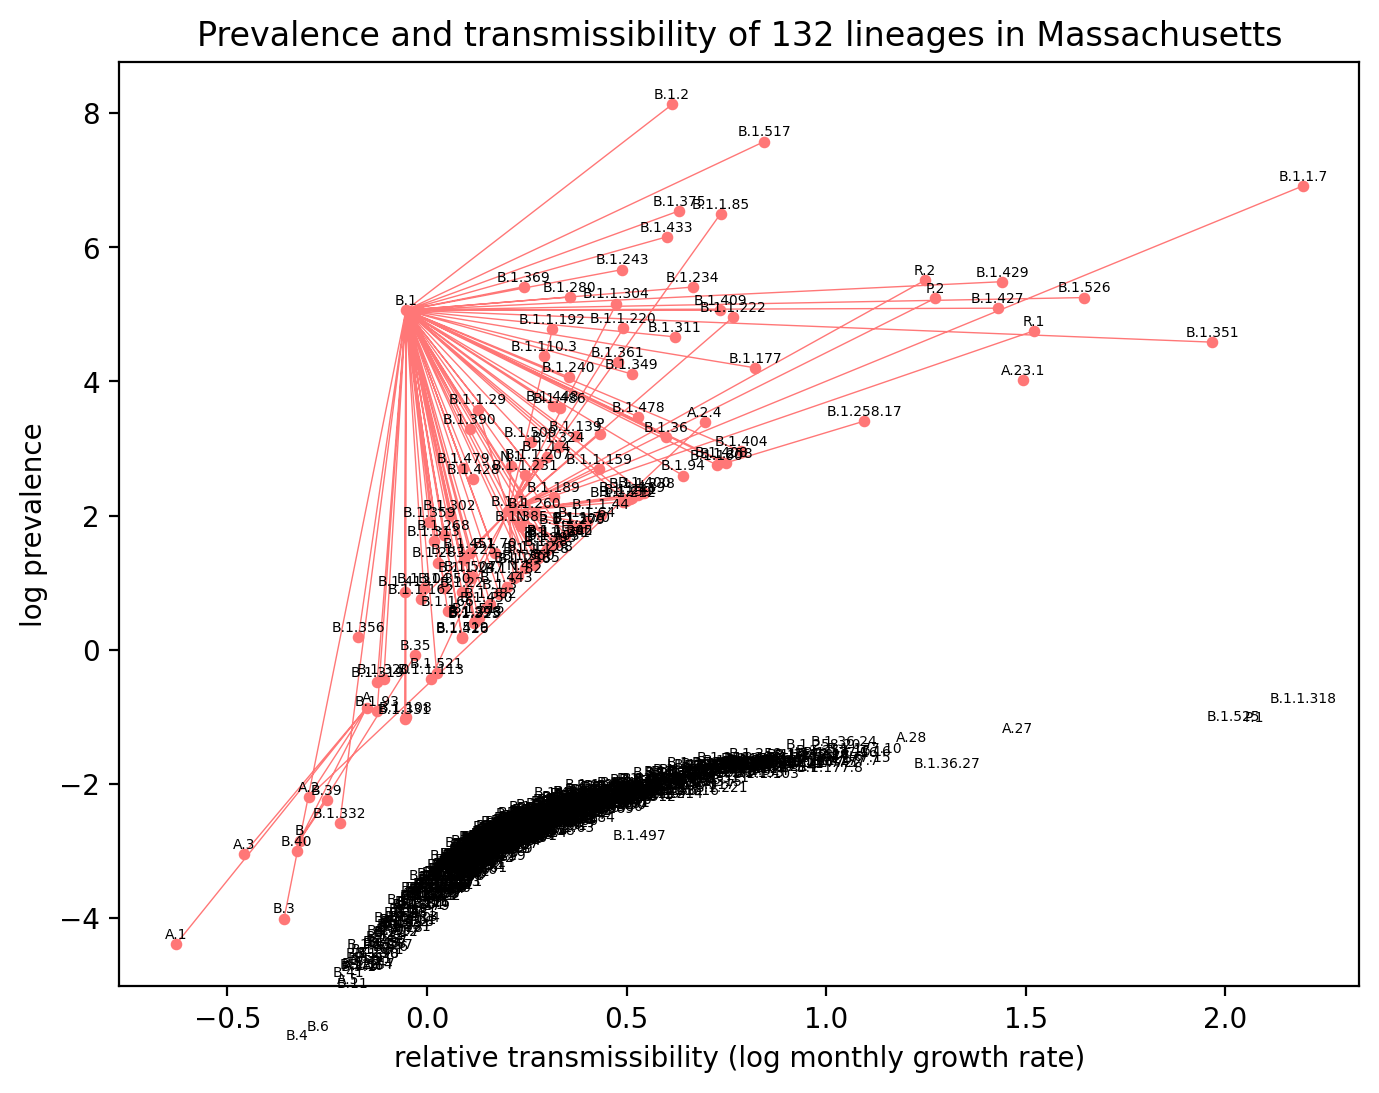

In [16]:
plot_prevalence("Massachusetts")

Finally we can use our logistic curves to forecast lineage prevalence in each region:

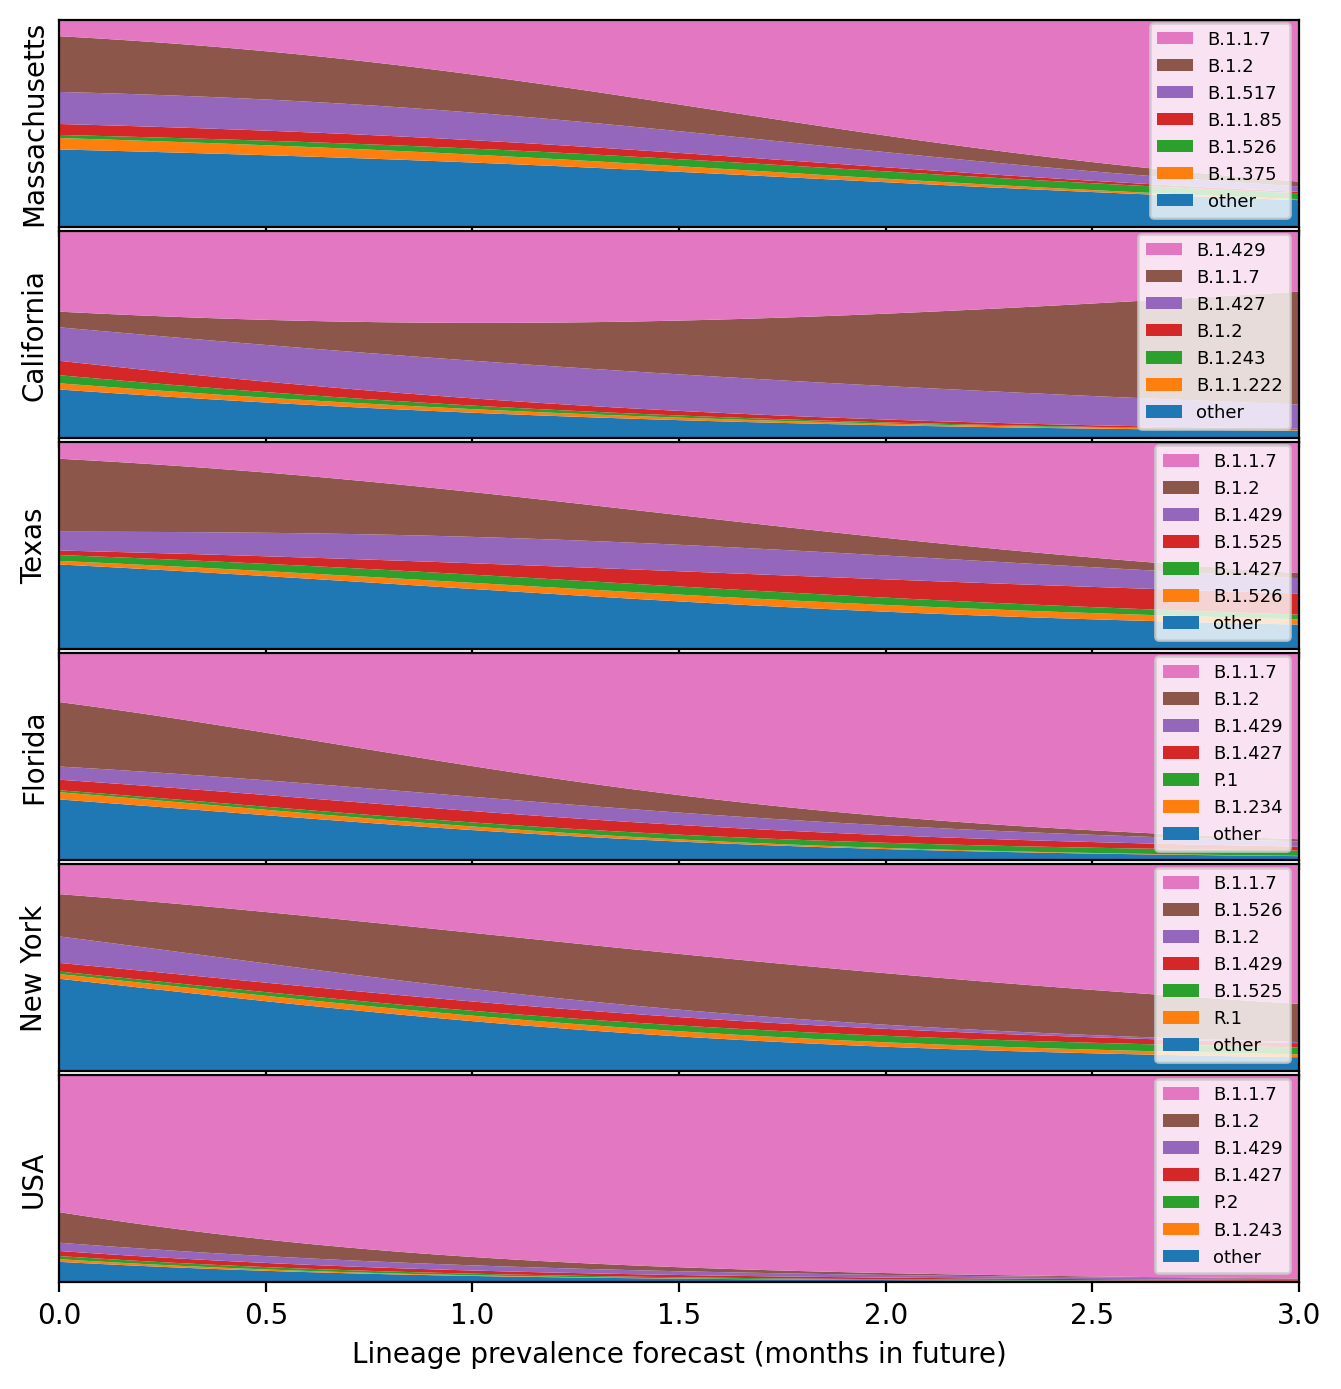

In [18]:
def plot_decomposition(queries, num_parts=7, months_ahead=3):
    if isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1 + 1.2 * len(queries)), sharex=True)
    for row, (place_query, ax) in enumerate(zip(queries, axes)):
        names = [name for name, i in location_id.items() if place_query in name]
        ids = [location_id[name] for name in names]
        assert ids, "no locations matching " + place_query
        log_rate = median["log_rate"]
        # FIXME this ignores region population when aggregating:
        log_init = median["log_init"][ids].logsumexp(0)
        assert log_init.shape == log_rate.shape
        time = torch.linspace(0, months_ahead / 12.0, 100)
        portion = (log_init + log_rate * time[:, None]).softmax(-1)

        # Aggregate into top + others.
        best = portion.sum(0).sort(0, descending=True).indices
        parts = {"other": None}
        for i in range(num_parts - 1):
            i = best[num_parts - i - 2].item()
            parts[lineage_id_inv[i]] = portion[:, i].clone()
            portion[:, i] = 0
        parts["other"] = portion.sum(-1)
        months = time * 12

        ax.stackplot(months, *parts.values(), labels=tuple(parts))
        ax.set_xlim(months.min(), months.max())
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(names[0].split("/")[-1].strip() if len(names) == 1 else place_query)
        if row == len(axes) - 1:
            ax.set_xlabel("Lineage prevalence forecast (months in future)")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="lower right", prop={"size": 6.5})
    plt.subplots_adjust(hspace=0.02);

plot_decomposition(["Mass", "Calif", "Texas", "Florida", "New York", "USA"])